# Week 6 Notebook - SVMs

If you want to run the svm_gui.py example as we do in class, you will need to remove matplotlib installed with Anaconda (which breaks tkinter support) and reinstall it with pip. Use the following commands:

<code>conda uninstall matplotlib
pip install matplotlib</code>

Then from your command line, you can launch the application with ipython after navigating to the right directory:

<code>ipython svm_gui.py</code>

## Iris SVMs

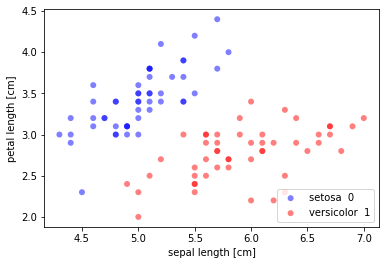

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
X = df.iloc[0:100, [0,1]].values
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

X_train, X_test, y_train, y_test =train_test_split(
    X, y, test_size=0.2, random_state=5)

stdscaler = preprocessing.StandardScaler().fit(X_train)
X_scaled  = stdscaler.transform(X)
X_train_scaled = stdscaler.transform(X_train)
X_test_scaled  = stdscaler.transform(X_test)

# plot data
plt.scatter(X[:50, 0], X[:50, 1],alpha=0.5, c='b', edgecolors='none', label='setosa %2s'%(y[0]))
plt.scatter(X[50:100, 0], X[50:100, 1],alpha=0.5, c='r', edgecolors='none', label='versicolor %2s'%(y[50]))
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='lower right')
plt.show()

def plot_decision_2d(clf,X,y,title="Decision Regions"):
    '''
    plot_decision_2d(clf,X,y)
    Plots a 2D decision region.
    '''
    # create a mesh to plot in
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

    h = (x_max-x_min)/1000.0 # step size in the mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)

    # Plot also the training points
    plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5, edgecolors='none')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.grid(alpha=0.2)
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         7

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Hinge loss 0.65


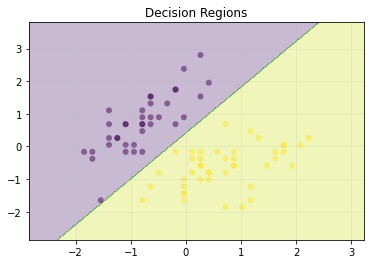

In [2]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import hinge_loss

svc = SVC(kernel='linear', C=1)
svc.fit(X_train_scaled, y_train)
predicted = svc.predict(X_test_scaled)
print(classification_report(y_test,predicted))
print("Hinge loss", hinge_loss(y_test,predicted))
plot_decision_2d(svc,X_train_scaled,y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         7

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Hinge loss 0.65


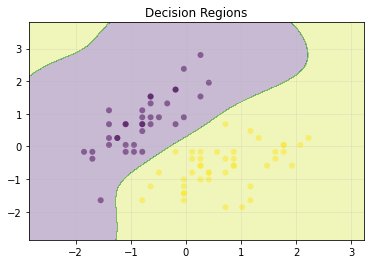

In [3]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import hinge_loss

svc = SVC(kernel='rbf', gamma=1, C=1)
svc.fit(X_train_scaled, y_train)
predicted = svc.predict(X_test_scaled)
print(classification_report(y_test,predicted))
print("Hinge loss", hinge_loss(y_test,predicted))
plot_decision_2d(svc,X_train_scaled,y_train)

              precision    recall  f1-score   support

           0       1.00      0.46      0.63        13
           1       0.50      1.00      0.67         7

    accuracy                           0.65        20
   macro avg       0.75      0.73      0.65        20
weighted avg       0.82      0.65      0.64        20

Hinge loss 1.0


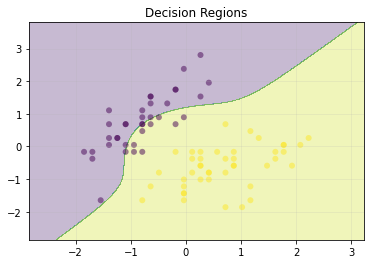

In [4]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import hinge_loss

svc = SVC(kernel='poly', degree=5, C=1)
svc.fit(X_train_scaled, y_train)
predicted = svc.predict(X_test_scaled)
print(classification_report(y_test,predicted))
print("Hinge loss", hinge_loss(y_test,predicted))
plot_decision_2d(svc,X_train_scaled,y_train)

## Disaster Tweets Revisitied: Cosine Similarity SVM

In [7]:
import pandas as pd
import numpy as np
from textblob import TextBlob
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import nltk
nltk.download('punkt')
nltk.download('wordnet')
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text
# If you are NOT using google colab, you need to take this part out starting from here
from google.colab import files

uploaded=files.upload()
# till here
tweets = pd.read_csv('socialmedia-disaster-tweets-DFE.csv',encoding='latin1')[['text','choose_one']]
tweets.columns = ['tweet','class']
tweets = tweets[(tweets['class'] == 'Relevant') | (tweets['class'] == 'Not Relevant')]
tweets = tweets.reset_index(drop=True)

# Clean tweet text of HTML, etc.
tweets['tweet'] = tweets.tweet.map(preprocessor)

# Reindex randomly
tweets = tweets.reindex(index=np.random.permutation(tweets.index))

# Setup transformer analyzer and subsequent bag-of-words transformer
from nltk.corpus import stopwords
from string import ascii_lowercase as alphabet

import nltk
nltk.download('stopwords')

stop = stopwords.words('english')
stop.extend([str(letter) for letter in alphabet])

def split_into_lemmas(tweet):
    tweet = str(tweet).lower()
    words = TextBlob(tweet).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words if word not in stop]

# Create bag-of-words transformer to apply to data in next cell
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(tweets.tweet)

# Transform the tweets in dataset to bag-of-words
tweets_bow = bow_transformer.transform(tweets.tweet)
print('sparse matrix shape:', tweets_bow.shape)
print('number of non-zeros:', tweets_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * tweets_bow.nnz / (tweets_bow.shape[0] * tweets_bow.shape[1])))

# Split resulting tweets_bow vector into traning and testing sets
tweets_bow_train = tweets_bow[:8000]
tweets_bow_test = tweets_bow[8000:]
tweets_class_train = tweets['class'][:8000]
tweets_class_test = tweets['class'][8000:]

print("Tweets training shape: ", tweets_bow_train.shape)
print("Tweets testomg shape:  ", tweets_bow_test.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Saving socialmedia-disaster-tweets-DFE.csv to socialmedia-disaster-tweets-DFE (2).csv
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
sparse matrix shape: (10860, 26236)
number of non-zeros: 118409
sparsity: 0.04%
Tweets training shape:  (8000, 26236)
Tweets testomg shape:   (2860, 26236)


In [8]:
from sklearn.naive_bayes import MultinomialNB

tweet_class_clf  = MultinomialNB().fit(tweets_bow_train, tweets_class_train)

predictions = tweet_class_clf.predict(tweets_bow_test)

print("Multinomial Naive Bayes Results: \n")

print(classification_report(tweets_class_test, predictions))

def predict_tweet(new_tweet): 
    new_sample = bow_transformer.transform([new_tweet])
    print(new_tweet)
    print("MNB Prediction: ", np.around(tweet_class_clf.predict_proba(new_sample), decimals=5),"\n")

predict_tweet('Cat stuck in a tree.')
predict_tweet('FIRE ABLAZE')

Multinomial Naive Bayes Results: 

              precision    recall  f1-score   support

Not Relevant       0.80      0.86      0.83      1602
    Relevant       0.80      0.73      0.76      1258

    accuracy                           0.80      2860
   macro avg       0.80      0.79      0.80      2860
weighted avg       0.80      0.80      0.80      2860

Cat stuck in a tree.
MNB Prediction:  [[0.69775 0.30225]] 

FIRE ABLAZE
MNB Prediction:  [[0.47584 0.52416]] 



In [9]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics.pairwise import cosine_similarity

tweet_class_svc = SVC(kernel=cosine_similarity, C=0.85).fit(tweets_bow_train, tweets_class_train)

predictions = tweet_class_svc.predict(tweets_bow_test)

print("SVC Results: \n")

print(classification_report(tweets_class_test, predictions))

def predict_tweet_svc(new_tweet): 
    new_sample = bow_transformer.transform([new_tweet])
    print(new_tweet)
    print("SVC Prediction: ", tweet_class_svc.predict(new_sample)[0], "\n")

predict_tweet_svc('Cat stuck in a tree.')
predict_tweet_svc('FIRE ABLAZE')

SVC Results: 

              precision    recall  f1-score   support

Not Relevant       0.79      0.89      0.84      1602
    Relevant       0.83      0.69      0.76      1258

    accuracy                           0.80      2860
   macro avg       0.81      0.79      0.80      2860
weighted avg       0.81      0.80      0.80      2860

Cat stuck in a tree.
SVC Prediction:  Not Relevant 

FIRE ABLAZE
SVC Prediction:  Relevant 

